## Script para obtener datos de los municipios

In [1]:
import requests
import time
import pprint
import pickle
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import xml.etree.ElementTree as ET
import re
import seaborn as sns
from unicodedata import normalize
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
%matplotlib
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def parseo_fecha_cuatrimeste(row):
    if row[1] == 'Primero':
        date = '01/01/'
    elif row[1] == 'Segundo':
        date = '01/04/'
    elif row[1] == 'Tercero':
        date = '01/07/'
    elif row[1] == 'Cuarto':
        date = '01/10/'
    return date+str(row[0])

def troceador_calles_api(street):
    words_street = []
    words_in_street = street.split(' ')
    for word in words_in_street:
        words = word.split(',')
        for w in words:
            if '/' in w:
                words.extend(w.split('/'))
        for w in words:
            if len(w) > 2 and w.upper() != 'DEL':
                words_street.append(w)
    return words_street
          
def comparador(streets_api, street_to_find):
    words_street_to_find = troceador_calles_api(street_to_find)
    streets = []
    for street in streets_api:
        words_street_api = troceador_calles_api(street)
        coincidences = 0
        for w1 in words_street_api:
            w1 = normalizador(w1)
            len_w1 = len(w1)
            coincidences_words = 0
            for w2 in words_street_to_find:
                w2 = normalizador(w2)
                if len_w1-1 < len(w2) < len_w1+1:
                    if w2 in w1:
                        coincidences_words += 1
            coincidences += coincidences_words
        if coincidences == len(words_street_to_find) and coincidences != 0:
            streets.append(street)
        elif coincidences >= max(int((len(words_street_api)+1)/2), int((len(words_street_to_find)+1)/2)):
            streets.append(street)
    
    if len(streets)==1:
        return streets[0]
    else:
        if len(set(streets))==1:
            return streets[0]
        else:
            for street in streets:
                if normalizador(street) in normalizador(street_to_find):
                    return street
            return False

def normalizador(string):
    string = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", str(string)), 0, re.I
    )
    string = string.lower()
    return normalize( 'NFC', string)

### Csv con los datos de la GR40

In [10]:
# NECESARIO EJECUTAR SCRIPT EN SAS PARA DESCARGAR LA TABLA QUE IMPORTAMOS A CONTINUACIÓN
#AL EJECUTAR ESTE SCRIPT ACTUALIZAMOS LAS VIVIENDAS QUE TENEMOS DISPONIBLES PARA EL MODELO
#lA SIGUIENTE TABLA ES LA GR_40 DE ORACLE (SAS)
data_oracle = pd.read_csv(r'C:\Users\Marta\Scripts - Presentación\DATOS_FINAL.csv', 
                   sep=';', engine="python", encoding="latin1")

In [11]:
#data_oracle= data_oracle.loc[:,['MATRICULA', 'DESMUNIC', 'DESPOBLACI', 'CODPOSTAL', 'FCHTASAC', 'SUPADAPT']]

### Lectura fomento municipios 

In [12]:
data_totales = pd.DataFrame()
data_antiguedad = pd.DataFrame()

for year in range(2005,2019):
    for trim in ['T1', 'T2', 'T3', 'T4']:
        name = trim+'A'+str(year)
        exec('data_'+name+'= pd.read_csv(r'+ '"' + "C:\\Users\\Marta\\Desktop\\Rotación 2 SBD\\BackUp_Proyecto\\Python Scripts\\Modelo evolución precios\\Datos\\Fomento\\Municipios\\Bruto\\" + name + '.csv", sep=";", engine="python", decimal=",", encoding="latin1", header=None)')
        
        if year < 2009:   
            exec('data_'+name+'='+'data_'+name+'[:283]')
        elif year < 2010 and trim in ['T1', 'T2']:
            exec('data_'+name+'='+'data_'+name+'[:283]')
        else:
            exec('data_'+name+'='+'data_'+name+'[:284]')
            
        if trim == 'T1':
            date = '01/01/'
        elif trim == 'T2':
            date = '01/04/'
        elif trim == 'T3':
            date = '01/07/'
        elif trim == 'T4':
            date = '01/10/'
        date = date + str(year)
            
        if year < 2010:  
            exec('data_'+name+'='+'data_'+name+'.loc[:,0:3]')
            exec('data_'+name+'.columns'+'='+'["Provincia", "Municipio", "valor promedio m2", "número de tasaciones"]')
            exec('data_'+name+'["Fecha"]'+'='+'"'+date+'"')
        else:
            exec('data_'+name+'='+'data_'+name+'.loc[:,0:7]')
            exec('data_'+name+'.columns'+'='+'["Provincia", "Municipio", "valor promedio m2 <=5 años", "valor promedio m2 >5 años", "valor promedio m2", "número de tasaciones <=5 años", "número de tasaciones >5 años", "número de tasaciones"]')
            exec('data_'+name+'["Fecha"]'+'='+'"'+date+'"')
            
        if year < 2010:
            exec('data_totales = data_totales.append(data_'+name+')')
        else:
            exec('data_totales = data_totales.append(data_'+name+'.loc[:,["Municipio", "valor promedio m2", "número de tasaciones", "Fecha"]])')
            exec('data_antiguedad = data_antiguedad.append(data_'+name+')')


data_antiguedad.index = range(len(data_antiguedad))
data_totales.index = range(len(data_totales))

data_totales.loc[:,'número de tasaciones'] = data_totales['número de tasaciones'].apply(lambda s: float(s))

def to_float(s):
    try:
        return float(s)
    except:
        return s

data_totales.loc[:,'valor promedio m2'] = data_totales['valor promedio m2'].apply(to_float)

data_totales.loc[data_totales['valor promedio m2'].apply(lambda s: type(s)==str),'valor promedio m2'] = [np.nan]*len(data_totales.loc[data_totales['valor promedio m2'].apply(lambda s: type(s)==str),'valor promedio m2'])

for element in ["valor promedio m2", "número de tasaciones"]:
    print(Counter(data_totales[element].apply(lambda s: type(s))))

C:\Users\Marta\Anaconda35\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Counter({<class 'float'>: 15886})
Counter({<class 'float'>: 15886})


### Tasaciones 

In [20]:
index_null_munic = data_oracle[data_oracle['DESMUNIC'].isnull()].index
data_oracle.loc[index_null_munic, 'DESMUNIC'] = data_oracle.loc[index_null_munic, 'DESPOBLACI']

munic_reference = data_totales['Municipio'].unique()

munic_to_replace = data_oracle[data_oracle['DESMUNIC'].notnull()]['DESMUNIC'].unique()

aux = []
for munic in munic_to_replace:
    if normalizador('Villajoyosa') in normalizador(munic):
        aux.append(munic)

dict_0 = {}
for munic_to_find in munic_reference:
    streets = []
    for munic in munic_to_replace:
        if normalizador(munic_to_find) in normalizador(munic):
            streets.append(munic)
    if len(streets) == 1:
        dict_0[munic_to_find] = streets[0]
    else:
        words1 = len(munic_to_find)
        for s in streets:
            words2 = len(s)
            if words2-1 < words1 < words2+1:
                dict_0[munic_to_find] = s

munic_reference = list(set(data_totales['Municipio'].unique())-set(dict_0.keys()))

dict_ = {}
for munic in munic_reference:
    dict_[munic] = comparador(munic_to_replace, munic)            

dict_0.update(dict_)

dict_0['San Cristóbal Laguna'] = 'SAN CRISTOBAL DE LA LAGUNA'
dict_0['Rinconada (La)'] = 'LA RINCONADA'
dict_0['Ejido (El)'] = 'EL EJIDO'
dict_0['Palmas de Gran Canaria (Las)'] = 'LAS PALMAS DE GRAN CANARIA'
dict_0['Villajoyosa/Vila Joiosa (La)'] = 'VILLAJOYOSA/LA VILA JOIOSA'
dict_0['San Cristóbal Laguna'] = 'SAN CRISTOBAL DE LA LAGUNA'
dict_0['Rozas de Madrid (Las)'] = 'LAS ROZAS DE MADRID'
dict_0['Vendrell (El)'] = 'EL VENDRELL'
dict_0['Santa Cruz deTenerife'] = 'SANTA CRUZ DE TENERIFE'

dict_to_replace = {}
for k, v in dict_0.items():
    dict_to_replace[v] = k

dict_to_replace['VILLAJOYOSA/LA VILA JOIOSA'] = 'Villajoyosa/Vila Joiosa (La)'
dict_to_replace['VILLAJOYOSA'] = 'Villajoyosa/Vila Joiosa (La)'
dict_to_replace['VILLAJOYOSA / VILA JOIOSA (LA)'] = 'Villajoyosa/Vila Joiosa (La)'
dict_to_replace['VILLAJOYOSA / VILA JOIOSA (L'] = 'Villajoyosa/Vila Joiosa (La)'
dict_to_replace['VILLAJOYOSA/ LA VILA JOIOSA'] = 'Villajoyosa/Vila Joiosa (La)'
dict_to_replace[' VILLAJOYOSA/LA VILA JOIOSA'] ='Villajoyosa/Vila Joiosa (La)'

data_oracle['Municipio'] = data_oracle['DESMUNIC'].map(dict_to_replace)
data_oracle_munic_fomento = data_oracle[data_oracle.Municipio.notnull()]

col_to_del = ['CODPOSTAL', 'DESMUNIC', 'DESPOBLACI']
for col in col_to_del:
    del data_oracle_munic_fomento[col]

data_oracle_munic_fomento = data_oracle_munic_fomento[data_oracle_munic_fomento['FCHTASAC'].notnull()]

data_oracle_munic_fomento.loc[:,'DIA'] = data_oracle_munic_fomento['FCHTASAC'].apply(lambda s: s[:2])
data_oracle_munic_fomento.loc[:,'MES'] = data_oracle_munic_fomento['FCHTASAC'].apply(lambda s: s[2:5])
data_oracle_munic_fomento.loc[:,'AÑO'] = data_oracle_munic_fomento['FCHTASAC'].apply(lambda s: int(s[5:9]))

del data_oracle_munic_fomento['FCHTASAC']

dict_cuatri = {'NOV':'Cuarto', 'SEP':'Tercero', 'OCT':'Cuarto', 'DEC':'Cuarto', 'MAR':'Primero', 'JAN':'Primero', 'MAY':'Segundo', 'FEB':'Primero', 'APR':'Segundo', 'JUN':'Segundo', 'JUL':'Tercero', 'AUG':'Tercero'}

data_oracle_munic_fomento['CUATRIMESTRE'] = data_oracle_munic_fomento['MES'].map(dict_cuatri)

data_oracle_munic_fomento['NUMERO_TASACIONES'] = [1]*len(data_oracle_munic_fomento)

data_oracle_munic_fomento = data_oracle_munic_fomento[data_oracle_munic_fomento['SUPADAPT']>=40]

In [21]:
columns_to_del = ['DIA', 'MES']
for col in columns_to_del:
    del data_oracle_munic_fomento[col]

data_oracle_munic_fomento = data_oracle_munic_fomento[(data_oracle_munic_fomento['AÑO']>1994)&(data_oracle_munic_fomento['AÑO']<2019)]

data_oracle_munic_fomento.head()

data_groupby = data_oracle_munic_fomento.groupby(['Municipio','AÑO','CUATRIMESTRE']).sum()


In [22]:
provinces = []
years = []
quarters = []
mean_m2s = []
num_tas = []
for province in data_groupby.index.levels[0]:
    for year in data_groupby.index.levels[1]:
        for quarter in data_groupby.index.levels[2]:
            try:
                aux = data_groupby.loc[province, year, quarter]
                mean_m2s.append(round(aux['IMPTOTAL']/aux['SUPADAPT'],2))
                num_tas.append(aux['NUMERO_TASACIONES'])
                provinces.append(province)
                years.append(year)
                quarters.append(quarter)
            except:
                pass

dict_to_df = {'MUNICIPIO':provinces, 'AÑO':years, 'CUATRIMESTRE':quarters, 'PROMEDIO m2':mean_m2s, 'NUMERO_TASACIONES':num_tas}
data = pd.DataFrame(dict_to_df)

In [23]:
data['Fecha'] = data.loc[:,['AÑO', 'CUATRIMESTRE']].apply(parseo_fecha_cuatrimeste,  axis=1)

columns_to_del = ['AÑO', 'CUATRIMESTRE']
for col in columns_to_del:
    del data[col]

data_merge = data_totales.merge(data, left_on=['Municipio', 'Fecha'], right_on=['MUNICIPIO', 'Fecha'],how='outer')


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [19]:

def munic_unique(row):
    if type(row[0]) == float:
        return row[1]
    elif type(row[1]) == float:
        return row[0]
    else:
        return row[0]

munics_join = data_merge.loc[:, ['Municipio', 'MUNICIPIO']].apply(munic_unique, axis=1)

col_to_del = ['MUNICIPIO']
for col in col_to_del:
    del data_merge[col]

data_merge.columns = ['Fecha', 'Municipio', 'Provincia', 'número de tasaciones fomento', 'valor promedio m2 fomento', 'valor promedio m2 garantías', 'número de tasaciones garantías']

data_merge.loc[:,'Municipio'] = munics_join

data_province = data_totales[data_totales['Fecha'].apply(lambda s: s=='01/10/2009')]

provinces_fill = list(data_province.loc[:,'Provincia'])

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [17]:



new_provinces = []
for iter_ in range(len(provinces_fill)):
    if type(provinces_fill[iter_]) == str:
        if provinces_fill[iter_] != ' ':
            new_provinces.append(provinces_fill[iter_])
        else:
            new_provinces.append(new_provinces[iter_ -1])
    else:
        new_provinces.append(new_provinces[iter_ -1])

data_province['Province'] = new_provinces

dict_provinces = {'ILLES BALEARS':'Illes Balears', 'ASTURIAS': 'Asturias', 'Santa Cruz de':'Santa Cruz de Tenerife', 'Tenerife':'Santa Cruz de Tenerife'}

data_province.replace({'Province':dict_provinces}, inplace=True)

data_to_dict = data_province.loc[:,['Municipio','Province']]

data_to_dict.index = range(len(data_to_dict))

dict_munic_provin = {}
for iter_ in data_to_dict.index:
    dict_munic_provin[data_to_dict.loc[iter_ ,'Municipio']] = data_to_dict.loc[iter_ ,'Province']

data_merge['Provincia'] = data_merge['Municipio'].map(dict_munic_provin)

data_merge.columns

cols = ['Fecha', 'Municipio', 'Provincia', 'número de tasaciones fomento',
       'valor promedio m2 fomento', 'valor promedio m2 garantías',
       'número de tasaciones garantías']
for element in cols:
    print(Counter(data_merge[element].apply(lambda s: type(s))))

data_merge.loc[data_merge['valor promedio m2 garantías']>5600, 'valor promedio m2 garantías'] = [np.nan]*len(data_merge.loc[data_merge['valor promedio m2 garantías']>5600, 'valor promedio m2 garantías'])

data_merge.head()

data_oracle_fomento_municipios= data_merge

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

### Banco de España 

In [7]:
#EL EXCEL QUE SE CARGA A CONTINUACIÓN DEBE MODIFICARSE A MANO (QUITAR CABECERA Y ASEGURARSE QUE NO HAY COLUMNAS O LÍNEAS EN BLANCO)

#TASA DUDOSIDAD
data = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos\Banco de España\Tasa_dudosidad.csv', 
                   sep=',', engine="python", encoding="latin1")

data = data.loc[3:,['Unnamed: 0', 'BE_4_13.4', 'BE_4_13.18']]

data.columns = ['Fecha', 'Saldo vivo', 'Saldo dudoso']

dict_cuatri = {'NOV':'Cuarto', 'SEP':'Tercero', 'OCT':'Cuarto', 'DIC':'Cuarto', 'MAR':'Primero', 'ENE':'Primero', 'JAN':'Primero', 'MAY':'Segundo', 'FEB':'Primero', 'APR':'Segundo', 'ABR':'Segundo', 'JUN':'Segundo', 'JUL':'Tercero', 'AUG':'Tercero', 'AGO':'Tercero'}

data.loc[:, 'MES'] = data['Fecha'].apply(lambda s: s.split(' ')[0])
data.loc[:, 'AÑO'] = data['Fecha'].apply(lambda s: s.split(' ')[1])

data['CUATRIMESTRE'] = data['MES'].map(dict_cuatri)

data['Fecha'] = data.loc[:,['AÑO', 'CUATRIMESTRE']].apply(parseo_fecha_cuatrimeste,  axis=1)

data = data[data['Saldo dudoso'].apply(lambda s: s != '_')]

data.loc[:, 'Porcentaje'] = data.apply(lambda s: (int(s[2])/int(s[1]))*100,  axis=1)

data.columns

col_to_del = ['Saldo vivo', 'Saldo dudoso', 'MES', 'AÑO', 'CUATRIMESTRE']
for col in col_to_del:
    del data[col]

data_dudosidad = data

data_dudosidad.columns = ['Fecha', 'Tasa de dudosidad']

#EURIBOR

data = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos\Banco de España\Euribor.csv', 
                   sep=',', engine="python", encoding="latin1")

data = data.loc[3:, ['Unnamed: 0', 'BE_1_15.7']]

data.columns = ['Fecha', 'Euribor']

data = data[data['Euribor'].apply(lambda s: s != '_')]

data.loc[:, 'MES'] = data['Fecha'].apply(lambda s: s.split(' ')[0])
data.loc[:, 'AÑO'] = data['Fecha'].apply(lambda s: s.split(' ')[1])

data['CUATRIMESTRE'] = data['MES'].map(dict_cuatri)

data['Fecha'] = data.loc[:,['AÑO', 'CUATRIMESTRE']].apply(parseo_fecha_cuatrimeste,  axis=1)

col_to_del = ['MES', 'AÑO', 'CUATRIMESTRE']
for col in col_to_del:
    del data[col]

data = data.groupby('Fecha').last().reset_index()

data_euribor = data

data= data_oracle_fomento_municipios

data_merge_dudosidad = data.merge(data_dudosidad, left_on=['Fecha'], right_on=['Fecha'], how='outer')

data_merge_dudosidad_euribor = data_merge_dudosidad.merge(data_euribor, left_on=['Fecha'], right_on=['Fecha'], how='outer')

data_merge_dudosidad_euribor[data_merge_dudosidad_euribor['Fecha']=='01/07/2018']

def euribor_to_float(s):
    if type(s)==str:
        return float(s)
    else:
        return s

data_merge_dudosidad_euribor['Euribor'] = data_merge_dudosidad_euribor['Euribor'].apply(euribor_to_float)
data_merge_dudosidad_euribor


,Fecha,Municipio,Provincia,número de tasaciones fomento,valor promedio m2 fomento,valor promedio m2 garantías,número de tasaciones garantías,Tasa de dudosidad,Euribor
0,01/01/2005,Almería,Almería,867.0,1477.4,1945.94,1.0,0.313759,2.335
1,01/01/2005,Roquetas de Mar,Almería,773.0,1484,2393.79,3.0,0.313759,2.335
2,01/01/2005,Ejido (El),Almería,513.0,1145.8,1642.23,7.0,0.313759,2.335
3,01/01/2005,Algeciras,Cádiz,718.0,1344.6,906.46,2.0,0.313759,2.335
4,01/01/2005,Arcos de la frontera,Cádiz,113.0,1052.9,NaN,NaN,0.313759,2.335
...,...,...,...,...,...,...,...,...,...
18228,01/04/1995,Elda,Alicante,NaN,NaN,476.42,1.0,NaN,NaN
18229,01/04/1995,Murcia,Murcia,NaN,NaN,441.43,2.0,NaN,NaN
18230,01/04/1995,Palma de Mallorca,Illes Balears,NaN,NaN,714.00,1.0,NaN,NaN
18231,01/01/1995,Getafe,Madrid,NaN,NaN,563.36,1.0,NaN,NaN


### Número de hipotecas 

In [8]:
#Falta esta tabla
data_ine = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos\INE\Hipotecas_constituidas.csv', 
                   sep=';', engine="python", decimal='.', encoding="latin1")

data_tablin = data = data_merge_dudosidad_euribor

data_ine = data_ine.iloc[:,:-1]

province_pc = list(data_ine.iloc[:, 0].apply(lambda s: s[:2]))
province_name = list(data_ine.iloc[:, 0].apply(lambda s: s[3:]))
for num_col in range(1, len(data_ine.columns)):
    
    date_year = [data_ine.columns[num_col][:4]]*len(data_ine)
    date_month = [data_ine.columns[num_col][5:]]*len(data_ine)
    value = list(data_ine.iloc[:, num_col])
    
    df_month = pd.DataFrame({'Código provincia':province_pc, 'Provincia':province_name,
                             'Año':date_year, 'Código mes':date_month, 'Hipotecas':value })
    
    if num_col == 1:
        df_ine = df_month
    else:
        df_ine = df_ine.append(df_month)

dict_month = {'01':'Primero', '02':'Primero', '03':'Primero', '04':'Segundo', '05':'Segundo', '06':'Segundo', '07':'Tercero', '08':'Tercero', '09':'Tercero', '10': 'Cuarto', '11':'Cuarto', '12':'Cuarto'} 

df_ine['Cuatrimestre'] = df_ine['Código mes'].map(dict_month)

df_ine['Fecha'] = df_ine.loc[:,['Año', 'Cuatrimestre']].apply(parseo_fecha_cuatrimeste,  axis=1)

col_to_del = ['Año', 'Código mes', 'Cuatrimestre']
for col in col_to_del:
    del df_ine[col]

prov_to_replace_tablin = {'Córdaba':'Córdoba', 'Valladodid':'Valladolid'}


data_tablin.replace({'Provincia':prov_to_replace_tablin}, inplace=True)

provinces_tablin = list(data_tablin.Provincia.unique())[:-1]

provinces_ine = list(df_ine.Provincia.unique())

dict_replace_prov_1 = {}
for munic_to_find in provinces_tablin:
    streets = []
    for munic in provinces_ine:
        if normalizador(munic_to_find) in normalizador(munic):
            streets.append(munic)
    if len(streets) == 1:
        dict_replace_prov_1[munic_to_find] = streets[0]
    else:
        words1 = len(munic_to_find)
        for s in streets:
            words2 = len(s)
            if words2-1 < words1 < words2+1:
                dict_replace_prov_1[munic_to_find] = s

dict_replace_prov_2 = {}
for munic in provinces_tablin:
    dict_replace_prov_2[munic] = comparador(provinces_ine, munic)     

dict_replace_prov_1.update(dict_replace_prov_2)

dict_to_replace = {}
for k, v in dict_replace_prov_1.items():
    dict_to_replace[v] = k

df_ine['Provincia'] = df_ine['Provincia'].map(dict_to_replace)

del df_ine['Código provincia']

df_ine_groupby_sum = df_ine.groupby(['Provincia', 'Fecha']).sum().reset_index()

df_ine_groupby_sum.head()

df_ine[(df_ine['Fecha']=='01/01/2018')&(df_ine['Provincia']=='Albacete')]

data_tablin_ine = data_tablin.merge(df_ine_groupby_sum, left_on=['Fecha', 'Provincia'],
                                    right_on=['Fecha', 'Provincia'], how='outer')

data_tablin_ine[data_tablin_ine['Fecha']=='01/01/2003']

data_tablin_ine.head()

,Fecha,Municipio,Provincia,número de tasaciones fomento,valor promedio m2 fomento,valor promedio m2 garantías,número de tasaciones garantías,Tasa de dudosidad,Euribor,Hipotecas
0,01/01/2005,Almería,Almería,867.0,1477.4,1945.94,1.0,0.313759,2.335,8156.0
1,01/01/2005,Roquetas de Mar,Almería,773.0,1484,2393.79,3.0,0.313759,2.335,8156.0
2,01/01/2005,Ejido (El),Almería,513.0,1145.8,1642.23,7.0,0.313759,2.335,8156.0
3,01/01/2005,Algeciras,Cádiz,718.0,1344.6,906.46,2.0,0.313759,2.335,8220.0
4,01/01/2005,Arcos de la frontera,Cádiz,113.0,1052.9,NaN,NaN,0.313759,2.335,8220.0


### Número de transacciones (fomento) 

In [9]:
data_tablin = data = data_tablin_ine

data_fomento = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos\Fomento\Bruto CSV\Resto\CSVs\Número total de transacciones inmobiliarias de viviendas por municipios.csv', 
                   sep=';', engine="python", decimal=',', encoding="latin1", header=None)

data_fomento = data_fomento.iloc[:-1,:61]

name_columns = ['Municipio']
for year in list(range(2004,2019)):
    for quarter in list(['Primero', 'Segundo', 'Tercero', 'Cuarto']):
        name_columns.append(str(year)+'_'+quarter)

data_fomento.columns = name_columns

def identify_row_to_del(row):
    number_blanks = 0
    for column in range(1, len(row)):
        if np.isnan(row[column]):
            number_blanks += 1
    if number_blanks == 60:
        return 1
    else:
        return 0

data_fomento['Row_to_del'] = data_fomento.apply(identify_row_to_del, axis=1)

data_fomento = data_fomento[data_fomento.Row_to_del!=1].iloc[:,:-1]

all_index_duplicated = set(data_fomento[data_fomento['Municipio'].duplicated(keep=False)].sort_values(by='Municipio').index)
first_index_duplicated = set(data_fomento[data_fomento['Municipio'].duplicated(keep=False)].sort_values(by='Municipio')['Municipio'].drop_duplicates().index)
index_to_drop = all_index_duplicated-first_index_duplicated

all_index = set(data_fomento.index)
index_not_duplicated = list(all_index-index_to_drop)

data_fomento = data_fomento.loc[index_not_duplicated]

df = pd.DataFrame()
municipality = data_fomento.iloc[:,0]
for col in data_fomento.columns[1:]:
    
    number_transactions = []
    year = [col.split('_')[0]]*len(data_fomento)
    quarter = [col.split('_')[1]]*len(data_fomento)
    
    for row_number in range(len(data_fomento)):
        
        number_transactions.append(data_fomento.iloc[row_number][col])

    if col == '2004_Primero':
        data_transacciones = pd.DataFrame({'Año':year, 'Trimestre':quarter, 'Municipio':municipality,
                                           'Nº transacciones inmobiliarias': number_transactions})
    else:
        data_transacciones = data_transacciones.append(pd.DataFrame({'Año':year, 'Trimestre':quarter, 'Municipio':municipality,
                                           'Nº transacciones inmobiliarias': number_transactions}))

        
data_transacciones['Fecha'] = data_transacciones.loc[:,['Año', 'Trimestre']].apply(parseo_fecha_cuatrimeste,  axis=1)

col_to_del = ['Año', 'Trimestre']
for col in col_to_del:
    del data_transacciones[col]

data_tablin.replace({'Municipio':{'Santa Cruz deTenerife': 'Santa Cruz de Tenerife', 'San Andrés  del Rabanedo': 'San Andrés del Rabanedo'}}, inplace=True)

munic_tablin = list(data_tablin.Municipio.unique())[:-1]

munic_fomento = list(data_transacciones.Municipio.unique())

a = []
for munic in munic_fomento:
    if 'Castellón' in munic:
        a.append(munic)

dict_munic_1 = {}
for munic_to_find in munic_tablin:
    munics = []
    for munic in munic_fomento:
        if (normalizador(munic_to_find) in normalizador(munic)) or (normalizador(munic) in normalizador(munic_to_find)):
            munics.append(munic)
    if len(munics) == 1:
        dict_munic_1[munics[0]] = munic_to_find
    else:
        words1 = len(munic_to_find)
        for s in munics:
            words2 = len(s)
            if words2-1 < words1 < words2+1:
                dict_munic_1[s] = munic_to_find

munics_not_found = list(set(munic_tablin)-set(list(dict_munic_1.values())))

dict_munic_2 = {}
for munic in munics_not_found:
    value = comparador(munic_fomento, munic)
    if value != False:
        dict_munic_2[value] = munic

dict_munic_1.update(dict_munic_2)

munics_not_found = list(set(munic_tablin)-set(list(dict_munic_1.values())))


dict_munic_1['Puerto de Santa María (El)'] = 'Puerto de Santa María'
dict_munic_1['Vélez-Málaga'] = 'Vélez Málaga'
dict_munic_1['Calp'] = 'Calpe/Calp'
dict_munic_1['Maó'] = 'Mahón'
dict_munic_1['Vitoria-Gasteiz'] = 'Vitoria'
dict_munic_1['San Vicente del Raspeig/Sant Vicent del '] = 'San Vicente del Raspeig'
dict_munic_1['Vila-real'] = 'Villarreal/Vila-real'
dict_munic_1['Donostia-San Sebastián'] = 'San Sebastián/Donostia'
dict_munic_1['Castellón de la Plana/Castelló de la Pla'] = 'Castellón de la Plana'


data_transacciones = data_transacciones[data_transacciones.Municipio.apply(lambda s: s in list(dict_munic_1.keys()))]

data_transacciones.Municipio = data_transacciones.Municipio.map(dict_munic_1)

data_tablin_transac = data_tablin.merge(data_transacciones, left_on=['Fecha', 'Municipio'],
                                    right_on=['Fecha', 'Municipio'], how='outer')

data_tablin_transac[(data_tablin_transac.Fecha == '01/07/2013') & (data_tablin_transac.Municipio == 'Mieres')]

data_tablin_transac.columns = ['Fecha', 'Municipio', 'Provincia', 'número de tasaciones fomento',
       'valor promedio m2 fomento', 'valor promedio m2 garantías',
       'número de tasaciones garantías', 'Tasa de dudosidad', 'Euribor',
       'Hipotecas', 'Transacciones inmobiliarias']
data_tablin_transac

,Fecha,Municipio,Provincia,número de tasaciones fomento,valor promedio m2 fomento,valor promedio m2 garantías,número de tasaciones garantías,Tasa de dudosidad,Euribor,Hipotecas,Transacciones inmobiliarias
0,01/01/2005,Almería,Almería,867.0,1477.4,1945.94,1.0,0.313759,2.335,8156.0,923.0
1,01/01/2005,Roquetas de Mar,Almería,773.0,1484,2393.79,3.0,0.313759,2.335,8156.0,775.0
2,01/01/2005,Ejido (El),Almería,513.0,1145.8,1642.23,7.0,0.313759,2.335,8156.0,681.0
3,01/01/2005,Algeciras,Cádiz,718.0,1344.6,906.46,2.0,0.313759,2.335,8220.0,550.0
4,01/01/2005,Arcos de la frontera,Cádiz,113.0,1052.9,NaN,NaN,0.313759,2.335,8220.0,211.0
...,...,...,...,...,...,...,...,...,...,...,...
19090,01/01/2008,Vall d'Uixó (la),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.0
19091,01/04/2008,Vall d'Uixó (la),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.0
19092,01/07/2008,Vall d'Uixó (la),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0
19093,01/01/2009,Vall d'Uixó (la),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0


### Parque de viviendas (fomento) 

In [10]:
data_tablin = data_tablin_transac

data_parque_viviendas = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos\Fomento\Bruto CSV\Resto\CSVs\Estimación del Parque de Viviendas.csv', 
                   sep=';', engine="python", encoding="latin1")

prov_to_del = ['TOTAL NACIONAL', 'Andalucía', 'Aragón', 'Canarias', 'Castilla y León', 'Castilla-La Mancha', 'Cataluña', 'Comunitat Valenciana', 'Extremadura', 'Galicia', 'País Vasco']

data_parque_viviendas = data_parque_viviendas.iloc[1:63,:18]

data_parque_viviendas = data_parque_viviendas[data_parque_viviendas['Unnamed: 0'].apply(lambda s: s not in prov_to_del)]

list(data_parque_viviendas.iloc[-1][1:])

new_c_y_m = ['Ceuta y Melilla']
for value in list(data_parque_viviendas.iloc[-1][1:]):
    new_c_y_m.append(float(int(int(value)/2)))

data_parque_viviendas.iloc[-1] = new_c_y_m

data_parque_viviendas = data_parque_viviendas.append(data_parque_viviendas.iloc[-1])

data_parque_viviendas.index = range(len(data_parque_viviendas))

prov_tablin = list(data_tablin.Provincia.unique())[:-1]

prov_fomento = list(data_parque_viviendas['Unnamed: 0'].unique())

dict_prov_1 = {}
for prov_to_find in prov_tablin:
    provs = []
    for prov in prov_fomento:
        if (normalizador(prov_to_find) in normalizador(prov)) or (normalizador(prov) in normalizador(prov_to_find)):
            provs.append(prov)
    if len(provs) == 1:
        dict_prov_1[provs[0]] = prov_to_find
    else:
        words1 = len(prov_to_find)
        for s in provs:
            words2 = len(s)
            if words2-1 < words1 < words2+1:
                dict_prov_1[s] = prov_to_find

provs_not_found = list(set(prov_tablin)-set(list(dict_prov_1.values())))

dict_prov_2 = {}
for prov in provs_not_found:
    value = comparador(prov_fomento, prov)
    if value != False:
        dict_prov_2[value] = prov

dict_prov_1.update(dict_prov_2)

provs_not_found = list(set(prov_tablin)-set(list(dict_prov_1.values())))

data_parque_viviendas['Provincia'] = data_parque_viviendas['Unnamed: 0'].map(dict_prov_1)

data_parque_viviendas.iloc[-1,-1] = 'Melilla'

del data_parque_viviendas['Unnamed: 0']

for year in data_parque_viviendas.columns[:-1]:
    years = ['01/01/'+year]*len(data_parque_viviendas)
    park_number = list(data_parque_viviendas[year])
    provinces = list(data_parque_viviendas['Provincia'])
    
    years.extend(['01/04/'+year]*len(data_parque_viviendas))
    park_number.extend(data_parque_viviendas[year])
    provinces.extend(list(data_parque_viviendas['Provincia']))
    
    years.extend(['01/07/'+year]*len(data_parque_viviendas))
    park_number.extend(data_parque_viviendas[year])
    provinces.extend(list(data_parque_viviendas['Provincia']))
    
    years.extend(['01/10/'+year]*len(data_parque_viviendas))
    park_number.extend(data_parque_viviendas[year])
    provinces.extend(list(data_parque_viviendas['Provincia']))
    
    if year == '2001':
        data_parque = pd.DataFrame({'Fecha':years, 'Parque viviendas':park_number, 'Provincias':provinces})
    else:
        data_parque = data_parque.append(pd.DataFrame({'Fecha':years, 'Parque viviendas':park_number, 'Provincias':provinces}))

data_parque.index = range(len(data_parque))

data_parque.columns = ['Fecha', 'Parque viviendas', 'Provincia']

data_tablin_parque = data_tablin.merge(data_parque, left_on=['Fecha', 'Provincia'],
                                    right_on=['Fecha', 'Provincia'], how='outer')

data_tablin_parque

,Fecha,Municipio,Provincia,número de tasaciones fomento,valor promedio m2 fomento,valor promedio m2 garantías,número de tasaciones garantías,Tasa de dudosidad,Euribor,Hipotecas,Transacciones inmobiliarias,Parque viviendas
0,01/01/2005,Almería,Almería,867.0,1477.4,1945.94,1.0,0.313759,2.335,8156.0,923.0,314757
1,01/01/2005,Roquetas de Mar,Almería,773.0,1484,2393.79,3.0,0.313759,2.335,8156.0,775.0,314757
2,01/01/2005,Ejido (El),Almería,513.0,1145.8,1642.23,7.0,0.313759,2.335,8156.0,681.0,314757
3,01/01/2005,Algeciras,Cádiz,718.0,1344.6,906.46,2.0,0.313759,2.335,8220.0,550.0,559465
4,01/01/2005,Arcos de la frontera,Cádiz,113.0,1052.9,NaN,NaN,0.313759,2.335,8220.0,211.0,559465
...,...,...,...,...,...,...,...,...,...,...,...,...
19330,01/10/2002,NaN,Ourense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201359
19331,01/10/2002,NaN,Araba/Alava,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128166
19332,01/10/2002,NaN,La Rioja,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160891
19333,01/10/2002,NaN,Ceuta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23447


### Visados obra nueva 

In [11]:
data_tablin = data_tablin_parque

data_obra_nueva = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos\Fomento\Bruto CSV\Resto\CSVs\Visados de nueva obra.csv', 
                   sep=';', engine="python", decimal=',', encoding="latin1", header=None)

data_obra_nueva = data_obra_nueva.iloc[:-2]

for row_number in data_obra_nueva.index:
    if np.isnan(data_obra_nueva.loc[row_number, 0]):
        data_obra_nueva.loc[row_number, 0] = data_obra_nueva.loc[row_number-1, 0]

data_obra_nueva.loc[:,0] = data_obra_nueva[0].apply(lambda s: str(int(s)))

dict_cuatri = {'NOV':'Cuarto', 'SEP':'Tercero', 'OCT':'Cuarto', 'DEC':'Cuarto', 'MAR':'Primero', 'JAN':'Primero', 'MAY':'Segundo', 'FEB':'Primero', 'APR':'Segundo', 'JUN':'Segundo', 'JUL':'Tercero', 'AUG':'Tercero'}

data_dict_months = data_obra_nueva.loc[:11,1:2]

cod_month = []
for i in range(12, 0, -1):
    cod_month.append(str(i))

data_dict_months[2] = cod_month

dict_months = {}
for index_ in data_dict_months.index:
    dict_months[data_dict_months.loc[index_, 1]] = data_dict_months.loc[index_, 2]

dict_month = {'1':'Primero', '2':'Primero', '3':'Primero', '4':'Segundo', '5':'Segundo', '6':'Segundo', '7':'Tercero', '8':'Tercero', '9':'Tercero', '10': 'Cuarto', '11':'Cuarto', '12':'Cuarto'} 

data_obra_nueva.columns = ['Año', 'Mes', 'Visados']

data_obra_nueva['Cuatrimestre'] = data_obra_nueva.iloc[:,1].map(dict_months).map(dict_month)

data_obra_nueva['Fecha'] = data_obra_nueva.loc[:,['Año', 'Cuatrimestre']].apply(parseo_fecha_cuatrimeste, axis=1)

del data_obra_nueva['Año']
del data_obra_nueva['Mes']

data_obra_nueva[data_obra_nueva.Fecha == '01/01/2005']

del data_obra_nueva['Cuatrimestre']

data_obra_nueva = data_obra_nueva.groupby(['Fecha']).sum().reset_index()

data_tablin_visados = data_tablin.merge(data_obra_nueva, left_on=['Fecha'],
                                    right_on=['Fecha'], how='outer')

data_tablin_visados[data_tablin_visados.Fecha == '01/10/2015']

,Fecha,Municipio,Provincia,número de tasaciones fomento,valor promedio m2 fomento,valor promedio m2 garantías,número de tasaciones garantías,Tasa de dudosidad,Euribor,Hipotecas,Transacciones inmobiliarias,Parque viviendas,Visados
12212,01/10/2015,Almería,Almería,423.0,1091,776.20,7.0,4.85192,0.059,948.0,403.0,397750,4402.0
12213,01/10/2015,Roquetas de Mar,Almería,461.0,939.9,946.43,10.0,4.85192,0.059,948.0,407.0,397750,4402.0
12214,01/10/2015,Ejido (El),Almería,262.0,806.7,245.15,1.0,4.85192,0.059,948.0,223.0,397750,4402.0
12215,01/10/2015,Algeciras,Cádiz,207.0,982.8,806.75,20.0,4.85192,0.059,1643.0,229.0,625020,4402.0
12216,01/10/2015,Arcos de la frontera,Cádiz,66.0,774.8,NaN,NaN,4.85192,0.059,1643.0,50.0,625020,4402.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12491,01/10/2015,Santurtzi,Bizkaia,25.0,2024.7,1321.79,1.0,4.85192,0.059,1949.0,105.0,545655,4402.0
12492,01/10/2015,Sestao,Bizkaia,26.0,1545.4,NaN,NaN,4.85192,0.059,1949.0,43.0,545655,4402.0
12493,01/10/2015,Logroño,La Rioja,228.0,1152.9,991.08,13.0,4.85192,0.059,379.0,411.0,201553,4402.0
12494,01/10/2015,Ceuta,Ceuta,103.0,1719.7,1273.04,5.0,4.85192,0.059,66.0,148.0,27249,4402.0


### PIB per cápita 

In [12]:
data_tablin = data_tablin_visados

data_pib = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos\INE\PIB_csv\PIB2.csv', 
                   sep=';', engine="python", encoding="latin1")

test = list(data_pib.columns)

test[3:len(test):3] = [str(i)+'_Valor' for i in range(2001, 2018)]

test[4:len(test):3] = [str(i)+'_Porcentaje' for i in range(2001, 2018)]

data_pib.columns = test

for col in test[5:len(test):3]:
    del data_pib[col]

data_pib.columns = ['Comunidad Autónoma', '2000_Valor', '2000_Porcentaje', '2001_Valor',
       '2001_Porcentaje', '2002_Valor', '2002_Porcentaje', '2003_Valor',
       '2003_Porcentaje', '2004_Valor', '2004_Porcentaje', '2005_Valor',
       '2005_Porcentaje', '2006_Valor', '2006_Porcentaje', '2007_Valor',
       '2007_Porcentaje', '2008_Valor', '2008_Porcentaje', '2009_Valor',
       '2009_Porcentaje', '2010_Valor', '2010_Porcentaje', '2011_Valor',
       '2011_Porcentaje', '2012_Valor', '2012_Porcentaje', '2013_Valor',
       '2013_Porcentaje', '2014_Valor', '2014_Porcentaje', '2015_Valor',
       '2015_Porcentaje', '2016_Valor', '2016_Porcentaje', '2017_Valor',
       '2017_Porcentaje']

data_pib = data_pib[1:]

last_value = ''
auto_com = []
for iter_ in data_pib.index:
    if iter_ == 1:
        last_value = data_pib.loc[iter_, '2017_Valor']
    else:
        if type(last_value) == str and type(data_pib.loc[iter_, '2017_Valor']) == float:
            auto_com.append(data_pib.loc[iter_ -1, 'Comunidad Autónoma'])
        last_value = data_pib.loc[iter_, '2017_Valor']

data_pib = data_pib[data_pib['Comunidad Autónoma'].apply(lambda s: s not in auto_com)]

def input_percentatges(row):
    if type(row[1]) == float:
        return row[0]
    else:
        return row[1]

data_pib['2017_Porcentaje'] = data_pib.loc[:, ['2016_Porcentaje', '2017_Porcentaje']].apply(input_percentatges, axis=1)

def input_value(row):
    if type(row[0]) == float:
        return round((float(row[1])/100)*25064)
    else:
        return row[0]

data_pib['2017_Valor'] = data_pib.loc[:, ['2017_Valor', '2017_Porcentaje']].apply(input_value, axis=1)

data_pib['2018_Valor'] = [' ']*len(data_pib)
data_pib['2018_Porcentaje'] = data_pib['2017_Porcentaje']

def input_value_2018(s):
    return round((float(s)/100)*25834)

data_pib['2018_Valor'] = data_pib.loc[:, ['2018_Porcentaje']].apply(input_value_2018, axis=1)

for col in data_pib.columns[2:len(data_pib.columns):2]:
    del data_pib[col]

['Provincia'].extend([str(i) for i in range(2000, 2019)])

new_names = ['Provincia']
new_names.extend([str(i) for i in range(2000, 2019)])
data_pib.columns = new_names

data_pib.iloc[:-1]

data_pib = data_pib.iloc[:-1]

prov_tablin = list(data_tablin.Provincia.unique())[:-1]
prov_fomento = list(data_pib.Provincia.unique())

dict_prov_1 = {}
for prov_to_find in prov_tablin:
    provs = []
    for prov in prov_fomento:
        if (normalizador(prov_to_find) in normalizador(prov)) or (normalizador(prov) in normalizador(prov_to_find)):
            provs.append(prov)
    if len(provs) == 1:
        dict_prov_1[provs[0]] = prov_to_find
    else:
        words1 = len(prov_to_find)
        for s in provs:
            words2 = len(s)
            if words2-1 < words1 < words2+1:
                dict_prov_1[s] = prov_to_find

provs_not_found = list(set(prov_tablin)-set(list(dict_prov_1.values())))

dict_prov_2 = {}
for prov in provs_not_found:
    value = comparador(prov_fomento, prov)
    if value != False:
        dict_prov_2[value] = prov

dict_prov_1.update(dict_prov_2)

provs_not_found = list(set(prov_tablin)-set(list(dict_prov_1.values())))

dict_prov_1['Coruña. A'] = 'La Coruña'
dict_prov_1['RIOJA. LA'] = 'La Rioja'

provs_not_found

data_pib['Provincia'] = data_pib.Provincia.map(dict_prov_1)

data_pib

provinces = list(data_pib.loc[:,'Provincia'])
provinces.extend(list(data_pib.loc[:,'Provincia']))
provinces.extend(list(data_pib.loc[:,'Provincia']))
provinces.extend(list(data_pib.loc[:,'Provincia']))
for col in data_pib.columns[1:]:
    pib = list(data_pib.loc[:,col])
    pib.extend(list(data_pib.loc[:,col]))
    pib.extend(list(data_pib.loc[:,col]))
    pib.extend(list(data_pib.loc[:,col]))

    year = ['01/01/'+col]*len(data_pib)
    year.extend(['01/04/'+col]*len(data_pib))
    year.extend(['01/07/'+col]*len(data_pib))
    year.extend(['01/10/'+col]*len(data_pib))
    
    if col == '2000':
        data_pib_parsed = pd.DataFrame({'Provincia':provinces, 'PIB per cápita':pib, 'Fecha':year})
    else:
        data_pib_parsed = data_pib_parsed.append(pd.DataFrame({'Provincia':provinces, 'PIB per cápita':pib, 'Fecha':year}))
    

data_pib_parsed[(data_pib_parsed['Fecha'] =='01/10/2009') & (data_pib_parsed['Provincia'] =='Illes Balears')]

data_tablin_pib = data_tablin.merge(data_pib_parsed, left_on=['Fecha','Provincia'], right_on=['Fecha','Provincia'], how='outer')

data_tablin_pib[(data_tablin_pib['Fecha'] =='01/04/2010') & (data_tablin_pib['Provincia'] =='Illes Balears')]

,Fecha,Municipio,Provincia,número de tasaciones fomento,valor promedio m2 fomento,valor promedio m2 garantías,número de tasaciones garantías,Tasa de dudosidad,Euribor,Hipotecas,Transacciones inmobiliarias,Parque viviendas,Visados,PIB per cápita
6022,01/04/2010,Calvià,Illes Balears,158.0,2667,NaN,NaN,2.597874,1.281,4870.0,231.0,585687,8520.0,24084
6023,01/04/2010,Ciutadella de Menorca,Illes Balears,72.0,2223.8,2146.30,1.0,2.597874,1.281,4870.0,123.0,585687,8520.0,24084
6024,01/04/2010,Eivissa,Illes Balears,86.0,2395.7,NaN,NaN,2.597874,1.281,4870.0,177.0,585687,8520.0,24084
6025,01/04/2010,Inca,Illes Balears,105.0,1598.3,NaN,NaN,2.597874,1.281,4870.0,82.0,585687,8520.0,24084
6026,01/04/2010,Llucmajor,Illes Balears,109.0,2026.6,1508.24,1.0,2.597874,1.281,4870.0,88.0,585687,8520.0,24084
6027,01/04/2010,Mahón,Illes Balears,72.0,1975.8,NaN,NaN,2.597874,1.281,4870.0,66.0,585687,8520.0,24084
6028,01/04/2010,Manacor,Illes Balears,103.0,1616.9,1585.49,1.0,2.597874,1.281,4870.0,114.0,585687,8520.0,24084
6029,01/04/2010,Marratxí,Illes Balears,120.0,2304.9,1772.87,1.0,2.597874,1.281,4870.0,79.0,585687,8520.0,24084
6030,01/04/2010,Palma de Mallorca,Illes Balears,1297.0,2118.7,2846.66,4.0,2.597874,1.281,4870.0,1111.0,585687,8520.0,24084
6031,01/04/2010,Santa Eulalia del Río,Illes Balears,46.0,2449.4,NaN,NaN,2.597874,1.281,4870.0,130.0,585687,8520.0,24084


### Desempleo 

In [13]:
data_tablin = data_tablin_pib

data_desempleo_1 = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos\INE\Desempleo\Desempleo-2002-2005.csv', 
                   sep=';', engine="python", decimal=',', encoding="latin1")
data_desempleo_2 = pd.read_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos\INE\Desempleo\Desempleo-2015-2018.csv', 
                   sep=';', engine="python", decimal=',', encoding="latin1")

col_to_del_1 = list(data_desempleo_1.columns[1:57])
col_to_del_1.extend(list(data_desempleo_1.columns[113:]))
for col in col_to_del_1:
    del data_desempleo_1[col]

col_to_del_2 = list(data_desempleo_2.columns[1:13])
col_to_del_2.extend(list(data_desempleo_2.columns[25:]))
for col in col_to_del_2:
    del data_desempleo_2[col]

data_desempleo_1.columns = data_desempleo_1.iloc[0,:]
data_desempleo_1 = data_desempleo_1.loc[1:]

data_desempleo_2.columns = data_desempleo_2.iloc[0,:]
data_desempleo_2 = data_desempleo_2.loc[1:]

data_desempleo = pd.concat([data_desempleo_2, data_desempleo_1.iloc[:,1:]], axis=1)

data_desempleo = data_desempleo.iloc[1:,:]

data_desempleo.index = range(len(data_desempleo))

data_desempleo['Provincia'] = data_desempleo.iloc[:, 0].apply(lambda s: s[3:])

data_desempleo = data_desempleo.iloc[:,1:]

prov_tablin = list(data_tablin.Provincia.unique())[:-1]
prov_fomento = list(data_desempleo.Provincia.unique())

dict_prov_1 = {}
for prov_to_find in prov_tablin:
    provs = []
    for prov in prov_fomento:
        if (normalizador(prov_to_find) in normalizador(prov)) or (normalizador(prov) in normalizador(prov_to_find)):
            provs.append(prov)
    if len(provs) == 1:
        dict_prov_1[provs[0]] = prov_to_find
    else:
        words1 = len(prov_to_find)
        for s in provs:
            words2 = len(s)
            if words2-1 < words1 < words2+1:
                dict_prov_1[s] = prov_to_find

provs_not_found = list(set(prov_tablin)-set(list(dict_prov_1.values())))

dict_prov_2 = {}
for prov in provs_not_found:
    value = comparador(prov_fomento, prov)
    if value != False:
        dict_prov_2[value] = prov

dict_prov_1.update(dict_prov_2)

provs_not_found = list(set(prov_tablin)-set(list(dict_prov_1.values())))

data_desempleo['Provincia'] = data_desempleo.Provincia.map(dict_prov_1)

data_desempleo.columns[:-1]

'2003T1'[:4]

provinces = data_desempleo.Provincia
dict_quarter = {'T1':'Primero', 'T2':'Segundo', 'T3':'Tercero', 'T4':'Cuarto'}
for col in data_desempleo.columns[:-1]:
    
    year = [col[:4]]*len(data_desempleo)
    quarter = [dict_quarter[col[4:]]]*len(data_desempleo)
    disemploy = data_desempleo.loc[:,col]
    
    if col == '2018T4':
        data_disemploy = pd.DataFrame({'Provincia':provinces, 'Año':year, 'Cuatrimestre':quarter, 'Tasa desempleo':disemploy})
    else:
        data_disemploy = data_disemploy.append(pd.DataFrame({'Provincia':provinces, 'Año':year, 'Cuatrimestre':quarter, 'Tasa desempleo':disemploy}))


data_disemploy['Fecha'] = data_disemploy.loc[:,['Año', 'Cuatrimestre']].apply(parseo_fecha_cuatrimeste,  axis=1)

col_to_del = ['Año', 'Cuatrimestre']
for col in col_to_del:
    del data_disemploy[col]

data_tablin_disemploy = data_tablin.merge(data_disemploy, left_on=['Fecha', 'Provincia'], right_on=['Fecha', 'Provincia'], how='outer')
data_tablin_disemploy


,Fecha,Municipio,Provincia,número de tasaciones fomento,valor promedio m2 fomento,valor promedio m2 garantías,número de tasaciones garantías,Tasa de dudosidad,Euribor,Hipotecas,Transacciones inmobiliarias,Parque viviendas,Visados,PIB per cápita,Tasa desempleo
0,01/01/2005,Almería,Almería,867.0,1477.4,1945.94,1.0,0.313759,2.335,8156.0,923.0,314757,26363.0,18927,8.78
1,01/01/2005,Roquetas de Mar,Almería,773.0,1484,2393.79,3.0,0.313759,2.335,8156.0,775.0,314757,26363.0,18927,8.78
2,01/01/2005,Ejido (El),Almería,513.0,1145.8,1642.23,7.0,0.313759,2.335,8156.0,681.0,314757,26363.0,18927,8.78
3,01/01/2005,Algeciras,Cádiz,718.0,1344.6,906.46,2.0,0.313759,2.335,8220.0,550.0,559465,26363.0,16370,19.12
4,01/01/2005,Arcos de la frontera,Cádiz,113.0,1052.9,NaN,NaN,0.313759,2.335,8220.0,211.0,559465,26363.0,16370,19.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19480,01/10/2000,NaN,Araba/Alava,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22065,NaN
19481,01/10/2000,NaN,Gipuzkoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20017,NaN
19482,01/10/2000,NaN,La Rioja,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17813,NaN
19483,01/10/2000,NaN,Ceuta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14350,NaN


### Generación tablin final 

C:\Users\Marta\Anaconda35\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Marta\Anaconda35\lib\site-packages\pandas_summary\__init__.py:91: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  stats.ix[columns, 'types'] = ctype


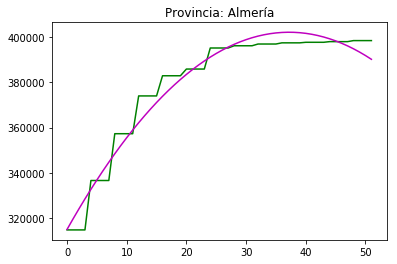

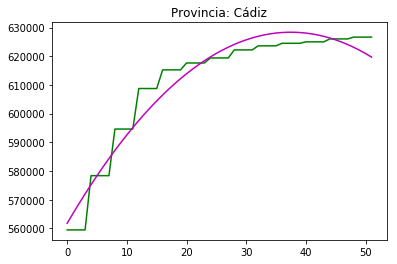

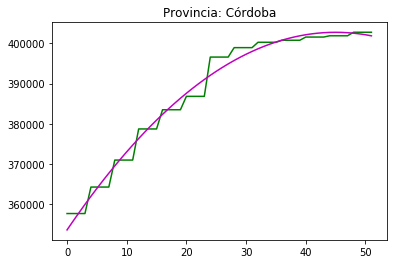

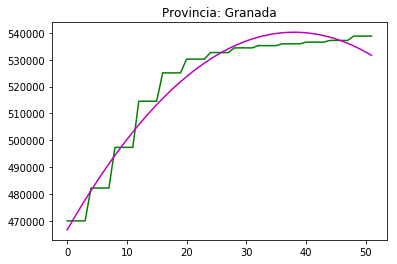

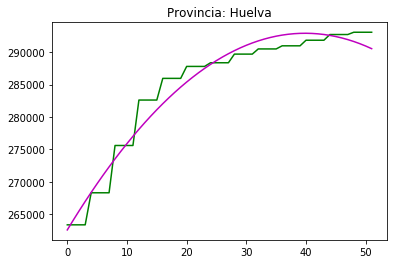

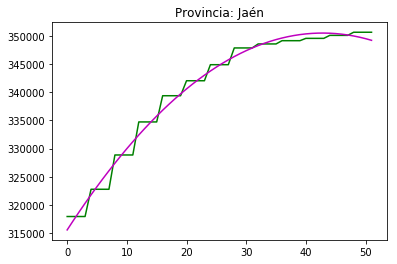

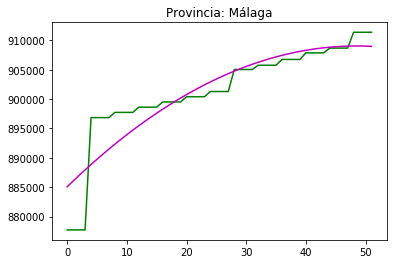

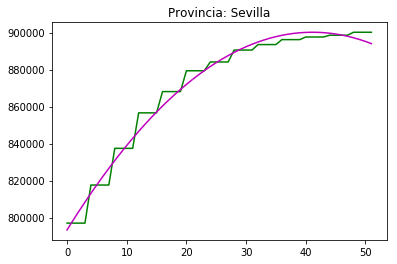

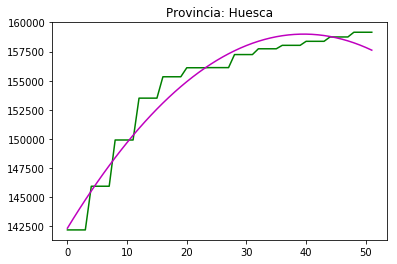

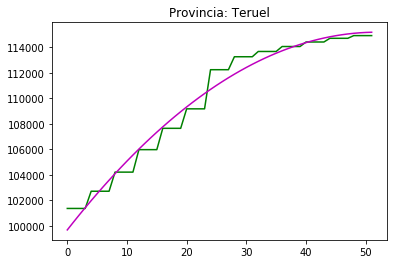

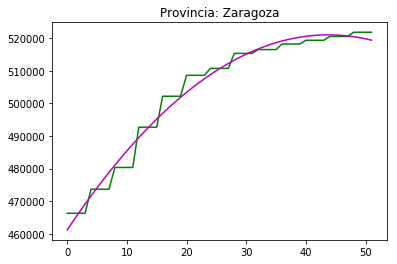

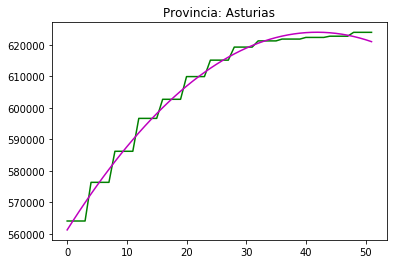

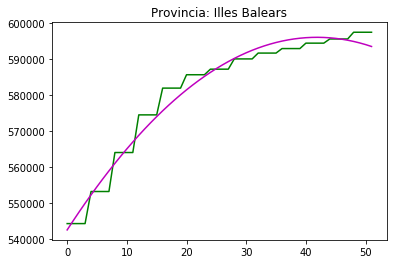

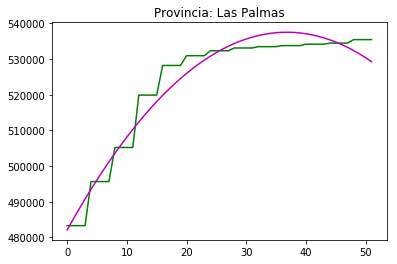

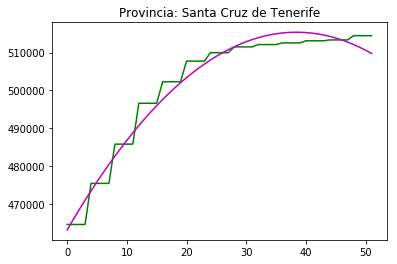

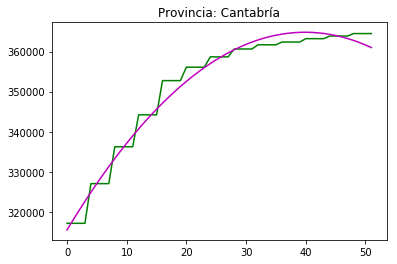

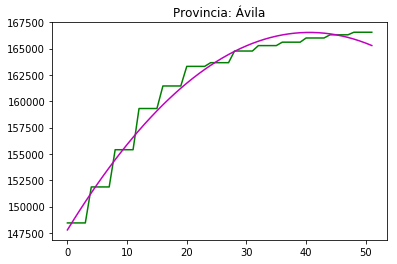

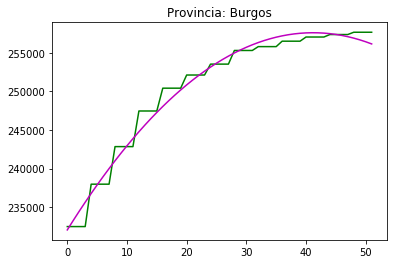

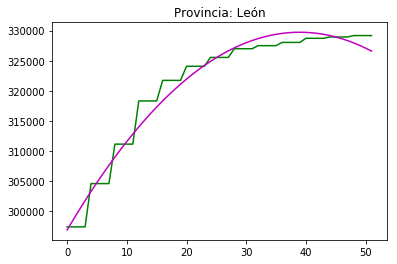

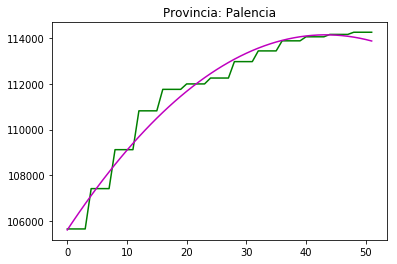

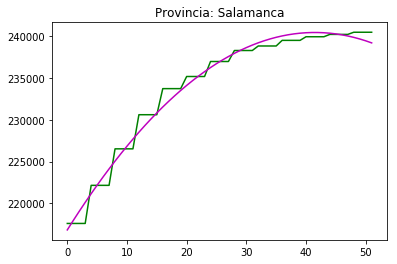

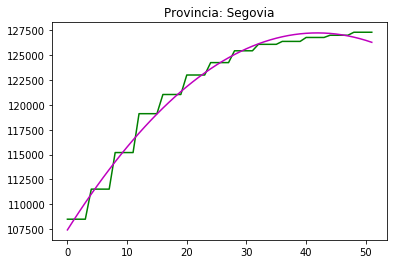

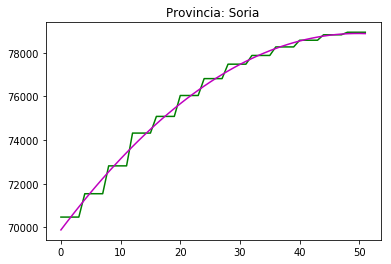

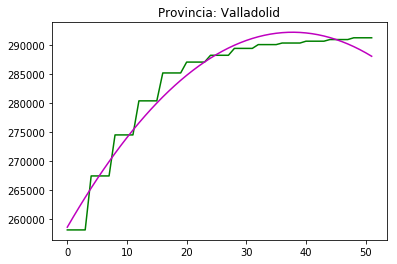

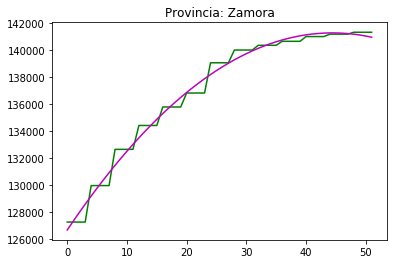

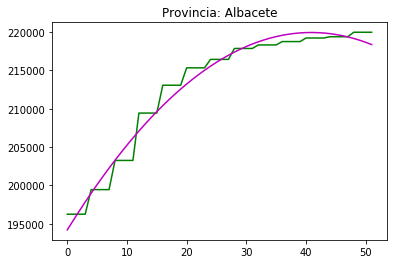

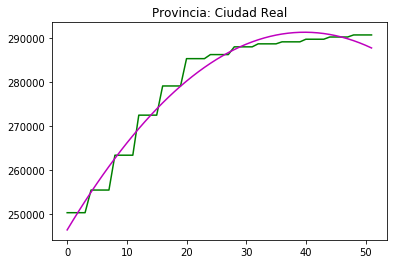

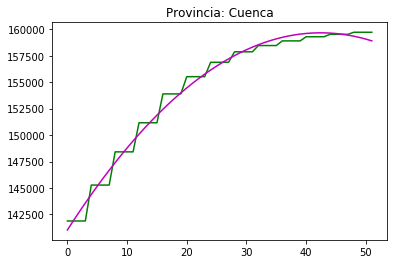

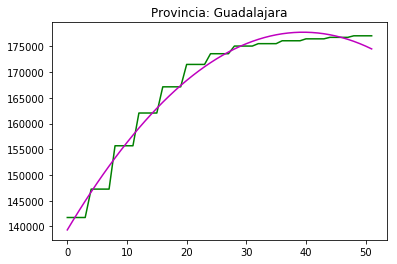

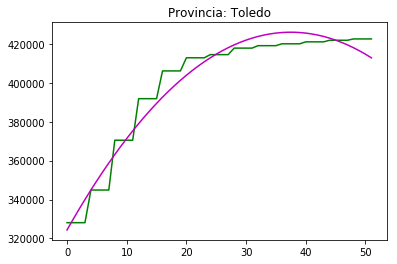

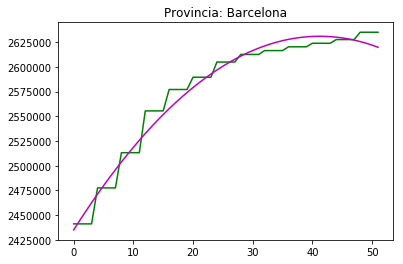

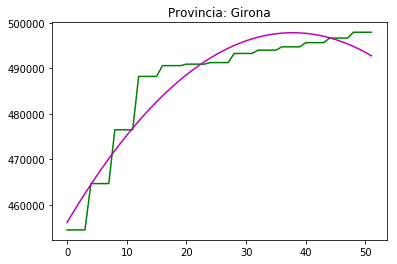

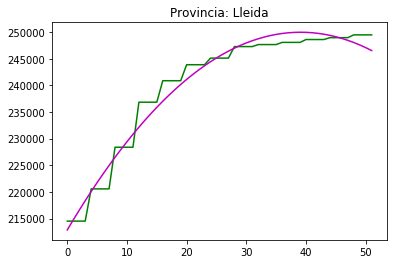

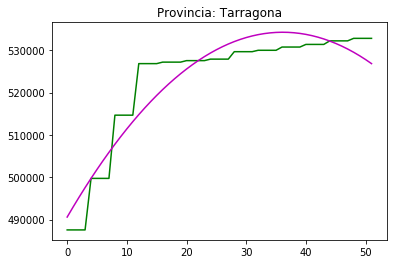

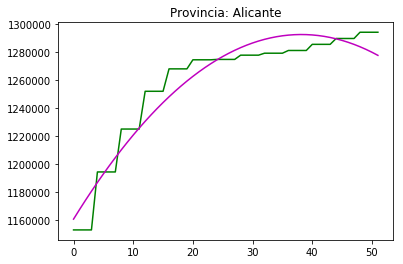

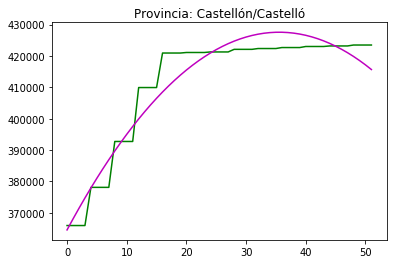

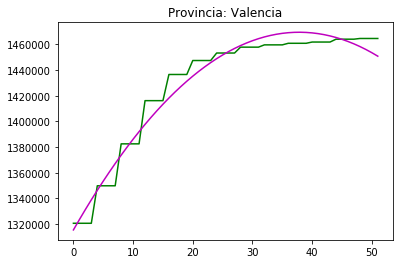

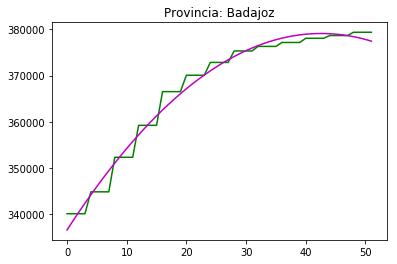

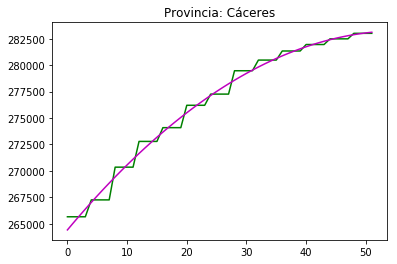

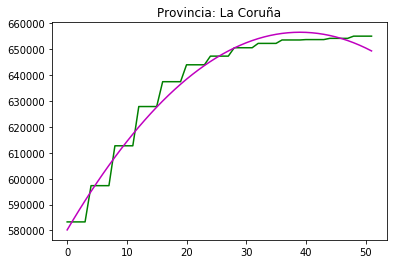

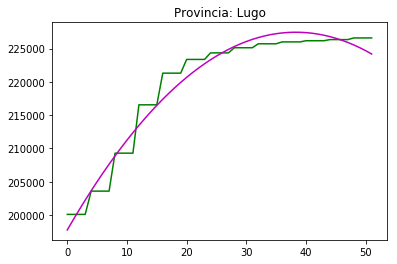

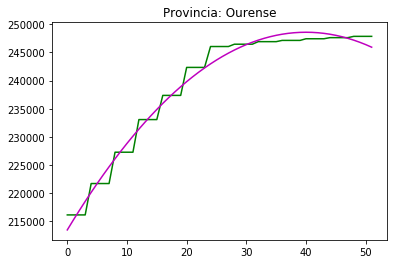

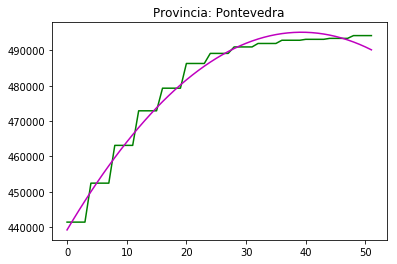

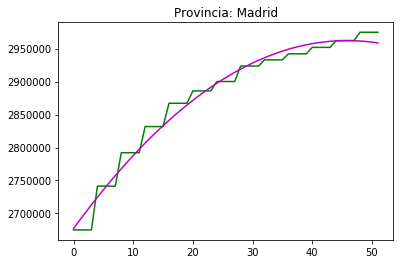

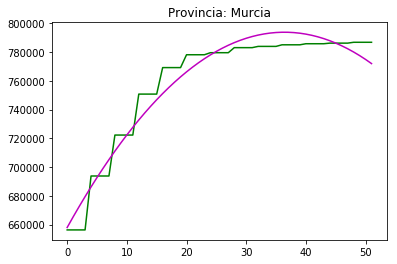

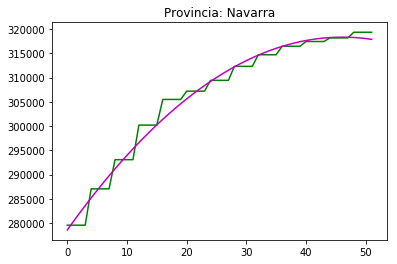

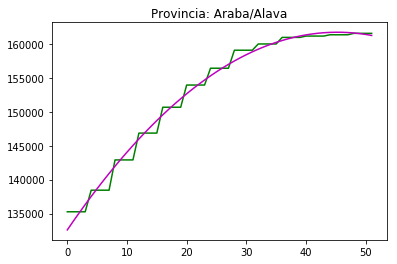

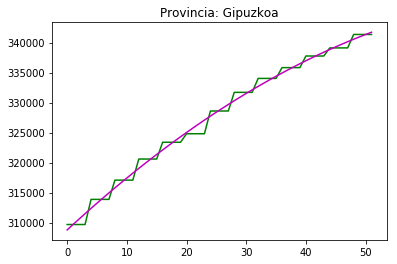

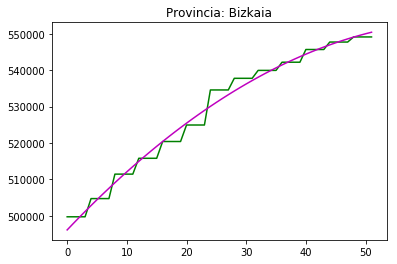

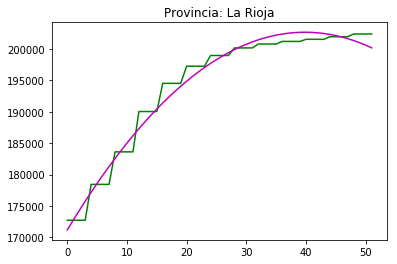

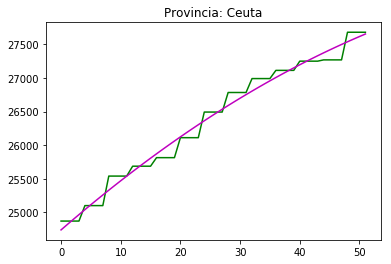

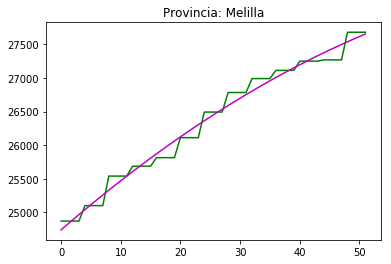

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [14]:
data_tablin = data_tablin_disemploy

data_tablin['Año'] = data_tablin.Fecha.apply(lambda s: int(s[6:]))  #crear columna año

tablin = data_tablin[(2004<data_tablin.Año)&(data_tablin.Año<2019)]   #solo tenemos datos de fomento del 2005 al 2018 

tablin.loc[tablin['valor promedio m2 garantías']>5600, 'valor promedio m2 garantías'] = [np.nan]*len(tablin.loc[tablin['valor promedio m2 garantías']>5600, 'valor promedio m2 garantías'])

tablin.loc[tablin['valor promedio m2 garantías'] >5600, 'valor promedio m2 garantías'].count()

tablin.loc[tablin['Fecha']==0, 'Fecha'].count()  

from pandas_summary import DataFrameSummary
ds = DataFrameSummary(tablin)
ds.columns_stats

#parque viviendas, tasa de dudosidad, número de tasaciones fomento y garantías y valor promedio m2 fomento y garantías tienen missings

#Expansión polinómica de grado 1 = regresión lineal para rellenar los missings de parque viviendas por provincia

poly = PolynomialFeatures( degree = 2 )
linear_regressor = linear_model.LinearRegression()

for province in tablin.Provincia.unique():

    data_test_regression = tablin.loc[
        tablin.Provincia==province,['Fecha','Parque viviendas','Provincia']].drop_duplicates()
    data_test_regression.index = range(len(data_test_regression))

    x = np.asarray(data_test_regression.index)
    y = np.asarray(data_test_regression.loc[:,['Parque viviendas']])

    xt = x.reshape( len(x), 1 )
    xt = xt[:-4]
    yt = y.reshape( len(y), 1 )
    yt = yt[:-4]

    X_  = poly.fit_transform( xt )

    linear_regressor.fit( X_, yt )

    values_to_pred = np.asarray([52,53,54,55]).reshape(4,1)

    predictions = linear_regressor.predict(poly.fit_transform( values_to_pred )).tolist()
    list_predictions = [round(item) for sublist in predictions for item in sublist]

    pyplot.title( "Provincia: %s" % province )
    plot1 = pyplot.plot( xt, yt, c='g' )
    plot2 = pyplot.plot( xt, linear_regressor.predict(X_), c='m' )
    
    pyplot.show()
    
    dates = ['01/01/2018', '01/04/2018', '01/07/2018', '01/10/2018']
    
    for index_ in range(4):
        
        tablin.loc[(tablin.Fecha==dates[index_])&(tablin.Provincia==province),'Parque viviendas'] = list_predictions[index_]
    

for element in ['número de tasaciones fomento',
       'valor promedio m2 fomento', 'valor promedio m2 garantías',
       'número de tasaciones garantías', 'Tasa de dudosidad', 'Euribor',
       'Hipotecas', 'Transacciones inmobiliarias', 'Parque viviendas',
       'PIB per cápita', 'Tasa desempleo', 'Año']:
    print(Counter(tablin[element].apply(lambda s: type(s))))

def pondated_sum(row):
    
    num_fom = row[0]
    val_fom = row[1]
    num_gar = row[3]
    val_gar = row[2]
    
    if np.isnan(val_fom) and (not np.isnan(val_gar)):
        return val_gar
    
    if np.isnan(val_gar) and (not np.isnan(val_fom)):
        return val_fom
    
    if (not np.isnan(num_fom)) and  (not np.isnan(val_fom)) and (not np.isnan(num_gar)) and (not np.isnan(val_gar)):        
        total_tas = num_fom+num_gar
        weight_fom = num_fom/total_tas
        weight_gar = num_gar/total_tas
        value = val_fom*weight_fom + val_gar*weight_gar
        return value

tablin['Valor metro cuadrado'] = tablin.loc[:,['número de tasaciones fomento', 'valor promedio m2 fomento', 
                                               'valor promedio m2 garantías', 'número de tasaciones garantías']].apply(pondated_sum, axis=1)

tablin_tas_na = tablin[tablin['Valor metro cuadrado'].isnull()]

fechas = list(tablin.Fecha.drop_duplicates())

dictionary_dates_date_to_num = {}
dictionary_dates_num_to_date = {}
for date_iter in range(len(fechas)):
    dictionary_dates_date_to_num[fechas[date_iter]] = date_iter
    dictionary_dates_num_to_date[date_iter] = fechas[date_iter]

for iter_ in tablin_tas_na.index:
    
    munic = tablin.loc[iter_,'Municipio']
    date = tablin.loc[iter_,'Fecha']
    prev_date = dictionary_dates_num_to_date[dictionary_dates_date_to_num[date]-1]
    next_date = dictionary_dates_num_to_date[dictionary_dates_date_to_num[date]+1]    
    prev_value = float(tablin[(tablin['Municipio']==munic)&(tablin['Fecha']==prev_date)]['Valor metro cuadrado'])
    next_value = float(tablin[(tablin['Municipio']==munic)&(tablin['Fecha']==next_date)]['Valor metro cuadrado'])
    
    while np.isnan(prev_value):
        prev_date = dictionary_dates_num_to_date[dictionary_dates_date_to_num[prev_date]-1]
        prev_value = float(tablin[(tablin['Municipio']==munic)&(tablin['Fecha']==prev_date)]['Valor metro cuadrado'])
    
    while np.isnan(next_value):
        next_date = dictionary_dates_num_to_date[dictionary_dates_date_to_num[next_date]+1]
        next_value = float(tablin[(tablin['Municipio']==munic)&(tablin['Fecha']==next_date)]['Valor metro cuadrado'])
    
    value_to_input = (prev_value+next_value)/2
    
    tablin.loc[(tablin['Municipio']==munic)&(tablin['Fecha']==date), 'Valor metro cuadrado'] = value_to_input


col_to_del = ['número de tasaciones fomento',
       'número de tasaciones garantías', 'Año']
for col in col_to_del:
    del tablin[col]


#Fill valor promedio m2 fomento con los que pueda de garantías
tablin['valor promedio m2 fomento'] = tablin['valor promedio m2 fomento'].fillna(value=tablin['valor promedio m2 garantías'])
#Aún quedan 46 missings


# MULTIPLE IMPUTATION (WITH MULTIVARIATE LINEAR REGRESSION)

linreg = LinearRegression()
data = tablin[['Euribor',
       'Hipotecas','PIB per cápita', 'Tasa desempleo','Valor metro cuadrado', 'valor promedio m2 fomento']]



#Step-1: Split the dataset that contains the missing values and no missing values on test and train respectively.
x_train = data[data['valor promedio m2 fomento'].notnull()].drop(columns='valor promedio m2 fomento')
y_train = data[data['valor promedio m2 fomento'].notnull()]['valor promedio m2 fomento']
x_test = data[data['valor promedio m2 fomento'].isnull()].drop(columns='valor promedio m2 fomento')
y_test = data[data['valor promedio m2 fomento'].isnull()]['valor promedio m2 fomento']

#We basically create a train set with all values except the rows with NA in 'valor fomento' and a test set with only the rows with NA
#The x are all the independent variables and the y is the dependent variable

#Step-2: Train the machine learning algorithm
linreg.fit(x_train, y_train)

#Step-3: Predict the missing values in the attribute of the test data.
predicted = linreg.predict(x_test)

#Step-4: Fill NA's with predicted values
tablin['valor promedio m2 fomento'][tablin['valor promedio m2 fomento'].isnull()] = predicted
tablin.info()

model =linreg.score(x_train, y_train)
print('coefficient of determination:', model)
print('intercept:', linreg.intercept_)
print('slope:', linreg.coef_)

ds = DataFrameSummary(tablin)
ds.columns_stats

# MULTIPLE IMPUTATION (WITH MULTIVARIATE LINEAR REGRESSION)

linreg = LinearRegression()
data = tablin[['Euribor',
       'Hipotecas','PIB per cápita', 'Tasa desempleo','Valor metro cuadrado', 'valor promedio m2 fomento','Tasa de dudosidad']]

#Step-1: Split the dataset that contains the missing values and no missing values on test and train respectively.
x_train = data[data['Tasa de dudosidad'].notnull()].drop(columns='Tasa de dudosidad')
y_train = data[data['Tasa de dudosidad'].notnull()]['Tasa de dudosidad']
x_test = data[data['Tasa de dudosidad'].isnull()].drop(columns='Tasa de dudosidad')
y_test = data[data['Tasa de dudosidad'].isnull()]['Tasa de dudosidad']

#We basically create a train set with all values except the rows with NA in 'valor fomento' and a test set with only the rows with NA
#The x are all the independent variables and the y is the dependent variable

#Step-2: Train the machine learning algorithm
linreg.fit(x_train, y_train)

#Step-3: Predict the missing values in the attribute of the test data.
predicted = linreg.predict(x_test)

#Step-4: Fill NA's with predicted values
tablin['Tasa de dudosidad'][tablin['Tasa de dudosidad'].isnull()] = predicted
tablin.info()

model =linreg.score(x_train, y_train)
print('coefficient of determination:', model)
print('intercept:', linreg.intercept_)
print('slope:', linreg.coef_)


colormap = plt.cm.RdBu
plt.figure(figsize=(32,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(tablin.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
# Note that the categorical features have been neglected in the
# correlation matrix.

col_to_del = ['valor promedio m2 garantías']
for col in col_to_del:
    del tablin[col]

ds = DataFrameSummary(tablin)
ds.columns_stats

tablin.to_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos - copia - Marta\tablin_datos_macros.csv', 
                   sep=';', encoding="latin1", decimal=',', index=False)

In [ ]:
#Quizás no necesito la regresión lineal

In [ ]:
#Regresión lineal

In [15]:
macros=tablin

In [16]:
#NUESTRA BASE DE DATOS
tablin = pd.read_csv(r'C:\Users\Marta\Scripts - Presentación\DATOS_FINAL.csv', 
                   sep=';', engine="python", encoding="latin1")
tablin= tablin.loc[:,['MATRICULA', 'CODPROVINC', 'FCHTASAC', 'IMPTOTAL', 'SUPADAPT']] #Eliminar esta línea si se quiere una tabla final con los datos macroeconómicos
tablin['Fecha']= pd.to_datetime(tablin['FCHTASAC'], format='%d%b%Y:%H:%M:%S')
del tablin['FCHTASAC']
tablin.columns= ['MATRICULA', 'Provincia', 'IMPTOTAL', 'SUPADAPT', 'Fecha']

In [17]:
macros= macros.loc[:,['Fecha', 'Municipio', 'Provincia','Tasa de dudosidad', 'Euribor',
       'Hipotecas', 'Transacciones inmobiliarias', 'Parque viviendas','PIB per cápita', 'Tasa desempleo']]
macros['Fecha']= pd.to_datetime(macros['Fecha'], format='%d/%m/%Y')

In [20]:
macros

,Fecha,Municipio,Provincia,Tasa de dudosidad,Euribor,Hipotecas,Transacciones inmobiliarias,Parque viviendas,PIB per cápita,Tasa desempleo
0,2005-01-01,Almería,Almería,0.313759,2.335,8156.0,923.0,314757,18927,8.78
1,2005-01-01,Roquetas de Mar,Almería,0.313759,2.335,8156.0,775.0,314757,18927,8.78
2,2005-01-01,Ejido (El),Almería,0.313759,2.335,8156.0,681.0,314757,18927,8.78
3,2005-01-01,Algeciras,Cádiz,0.313759,2.335,8220.0,550.0,559465,16370,19.12
4,2005-01-01,Arcos de la frontera,Cádiz,0.313759,2.335,8220.0,211.0,559465,16370,19.12
...,...,...,...,...,...,...,...,...,...,...
15899,2018-10-01,Santurtzi,Bizkaia,NaN,-0.129,2051.0,182.0,551804,32577,11.47
15900,2018-10-01,Sestao,Bizkaia,NaN,-0.129,2051.0,58.0,551804,32577,11.47
15901,2018-10-01,Logroño,La Rioja,NaN,-0.129,495.0,533.0,198097,26997,10.3
15902,2018-10-01,Ceuta,Ceuta,NaN,-0.129,80.0,209.0,27796,20151,24.02


In [18]:
tablin['Provincia'] = tablin['Provincia'].map(dict_prov)   #Aquí finalmente reemplazamos los municipios de "macros" por los nuevos

NameError: name 'dict_prov' is not defined

In [ ]:
#Función para normalizar los nombres de las viviendas (eliminar carácteres raros incluyendo acentos)
def normalizador(string):
    string = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", str(string)), 0, re.I)
    string = string.lower()
    return normalize( 'NFC', string)

def troceador_calles_api(street):
    words_street = []
    words_in_street = street.split(' ')
    for word in words_in_street:
        words = word.split(',')
        for w in words:
            if '/' in w:
                words.extend(w.split('/'))
        for w in words:
            if len(w) > 2 and w.upper() != 'DEL':
                words_street.append(w)
    return words_street

def comparador(streets_api, street_to_find):
    words_street_to_find = troceador_calles_api(street_to_find)
    streets = []
    for street in streets_api:
        words_street_api = troceador_calles_api(street)
        coincidences = 0
        for w1 in words_street_api:
            w1 = normalizador(w1)
            len_w1 = len(w1)
            coincidences_words = 0
            for w2 in words_street_to_find:
                w2 = normalizador(w2)
                if len_w1-1 < len(w2) < len_w1+1:
                    if w2 in w1:
                        coincidences_words += 1
            coincidences += coincidences_words
        if coincidences == len(words_street_to_find) and coincidences != 0:
            streets.append(street)
        elif coincidences >= max(int((len(words_street_api)+1)/2), int((len(words_street_to_find)+1)/2)):
            streets.append(street)
    
    if len(streets)==1:
        return streets[0]
    else:
        if len(set(streets))==1:
            return streets[0]
        else:
            for street in streets:
                if normalizador(street) in normalizador(street_to_find):
                    return street
            return False

In [19]:
munic_reference = tablin[tablin['Municipio'].notnull()]['Municipio'].unique()    #municipios de referencia
munic_to_replace = macros[macros['Municipio'].notnull()]['Municipio'].unique()  #municipios que hay que reemplazar

#Esto crea un diccionario para que los municipios a reemplazar se transformen para ser lo más parecidos a los de referencia
dict_0 = {}
for munic_to_find in munic_reference:  #municipios de referencia (quiero que los munic sean igual a los munic_to_find)
    streets = []
    for munic in munic_to_replace:  #municipios a reemplazar
        if normalizador(munic_to_find) in normalizador(munic):
            streets.append(munic)
    if len(streets) == 1:
        dict_0[munic_to_find] = streets[0]
    else:
        words1 = len(munic_to_find)
        for s in streets:
            words2 = len(s)
            if words2-1 < words1 < words2+1:
                dict_0[munic_to_find] = s

KeyError: 'Municipio'

In [ ]:
#Crea un nuevo diccionario (dict_) que compara los municipios de referencia con los que había que reemplazar después del procesamiento
munic_reference = list(set(tablin['Municipio'].unique())-set(dict_0.keys()))
munic_reference = [i for i in munic_reference if str(i) != 'nan']
dict_ = {}
for munic in munic_reference:
    dict_[munic] = comparador(munic_to_replace, munic)            

dict_0.update(dict_)

#ESTA PARTE SÓLO ES PARA VER SI LO HEMOS HECHO BIEN
#Esto crea un diccionario con los nombres que no han coincidido entre las dos tablas después de procesarlos
newdict={}
for (key, value) in dict_.items():
   if value != False:
       newdict[key] = value

#Esto elimina los duplicados del diccionario
result = {}

for key,value in newdict.items():
    if value not in result.values():
        result[key] = value

len(result)

#En result podemos ver los nombres que siguen sin estar iguales en las dos tablas

#dict_0 es el diccionario donde estamos procesando los nombres y el que queremos usar para modificar los nombres en la tabla
dict_0['San Cristóbal Laguna'] = 'SAN CRISTOBAL DE LA LAGUNA'
dict_0['Rinconada (La)'] = 'LA RINCONADA'
dict_0['Ejido (El)'] = 'EL EJIDO'
dict_0['Palmas de Gran Canaria (Las)'] = 'LAS PALMAS DE GRAN CANARIA'
dict_0['Villajoyosa/Vila Joiosa (La)'] = 'VILLAJOYOSA/LA VILA JOIOSA'
dict_0['San Cristóbal Laguna'] = 'SAN CRISTOBAL DE LA LAGUNA'
dict_0['Rozas de Madrid (Las)'] = 'LAS ROZAS DE MADRID'
dict_0['Vendrell (El)'] = 'EL VENDRELL'
dict_0['Santa Cruz deTenerife'] = 'SANTA CRUZ DE TENERIFE'

len(result)

dict_to_replace = {}
for k, v in dict_0.items():
    dict_to_replace[v] = k

dict_to_replace['VILLAJOYOSA/LA VILA JOIOSA'] = 'Villajoyosa/Vila Joiosa (La)'
dict_to_replace['VILLAJOYOSA'] = 'Villajoyosa/Vila Joiosa (La)'
dict_to_replace['VILLAJOYOSA / VILA JOIOSA (LA)'] = 'Villajoyosa/Vila Joiosa (La)'
dict_to_replace['VILLAJOYOSA / VILA JOIOSA (L'] = 'Villajoyosa/Vila Joiosa (La)'
dict_to_replace['VILLAJOYOSA/ LA VILA JOIOSA'] = 'Villajoyosa/Vila Joiosa (La)'
dict_to_replace[' VILLAJOYOSA/LA VILA JOIOSA'] ='Villajoyosa/Vila Joiosa (La)'

macros['Municipio'] = macros['Municipio'].map(dict_to_replace)   #Aquí finalmente reemplazamos los municipios de "macros" por los nuevos

In [ ]:
tablin

In [ ]:
macros

In [ ]:
tablin.merge(macros, left_on=['Fecha', 'Provincia'], right_on=['Fecha','Provincia'])

In [ ]:
macros['Fecha'].min()     #Como sólo tenemos información macroeconómica hasta el 2005 sólo entrarán las viviendas tasadas a partir de 2005

In [ ]:
tablin.to_csv(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\Modelo evolución precios\Datos - copia - Marta\tablin_datos_completos.csv', 
                   sep=';', encoding="latin1", decimal=',', index=False)